In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    plot_confusion_matrix, plot_roc_curve, f1_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Importing data

In [3]:
accepted_loans = pd.read_csv('/content/drive/MyDrive/Lending Club Data/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [ ]:
accepted_loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
accepted_loans['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

# Exploratory Data Analysis

## Considering only 'Fully Paid' and 'Charged Off' status


In [4]:
accepted_loans = accepted_loans[(accepted_loans['loan_status'] == 'Fully Paid') | (accepted_loans['loan_status'] == 'Charged Off')]
accepted_loans.shape

(1345310, 151)

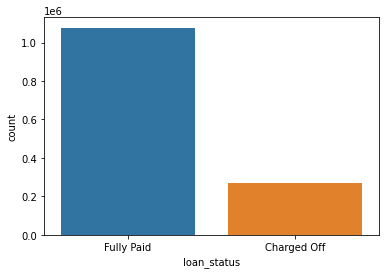

In [ ]:
sns.countplot(x=accepted_loans['loan_status'], data=accepted_loans)

In [ ]:
num_fully_paid_loans = accepted_loans[accepted_loans['loan_status'] == 'Fully Paid'].shape[0]
num_charged_off_loans = accepted_loans[accepted_loans['loan_status'] == 'Charged Off'].shape[0]
print(num_fully_paid_loans)
print(num_charged_off_loans)
print(num_fully_paid_loans / num_charged_off_loans)

1076751
268559
4.009364795072964


## Data Cleaning

### Percentage of missing values per column

In [ ]:
accepted_loans.isnull().sum().sort_values(ascending=False)
# Can't compute percentage here because of ram limitation

next_pymnt_d                                  1345310
member_id                                     1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_length                               1339556
                                               ...   
pub_rec                                             0
open_acc                                            0
fico_range_high                                     0
fico_range_low                                      0
id                                                  0
Length: 151, dtype: int64

### Dropping features having too much missing data

In [5]:
# dropping columns have more than 50% missing data
keeping_columns = accepted_loans.columns[accepted_loans.isnull().sum() < (len(accepted_loans) / 2)].to_list()
len(keeping_columns)

93

In [6]:
accepted_loans = accepted_loans[keeping_columns]

In [ ]:
(accepted_loans.isnull().sum() / len(accepted_loans) * 100).sort_values(ascending=False).head(50)

mths_since_recent_inq         12.939100
num_tl_120dpd_2m               8.726688
mo_sin_old_il_acct             7.847634
emp_title                      6.376597
emp_length                     5.835904
pct_tl_nvr_dlq                 5.030885
avg_cur_bal                    5.021073
num_rev_accts                  5.019512
mo_sin_rcnt_rev_tl_op          5.019512
mo_sin_old_rev_tl_op           5.019512
mo_sin_rcnt_tl                 5.019438
num_rev_tl_bal_gt_0            5.019438
num_accts_ever_120_pd          5.019438
num_actv_bc_tl                 5.019438
num_actv_rev_tl                5.019438
num_bc_tl                      5.019438
tot_coll_amt                   5.019438
total_rev_hi_lim               5.019438
num_op_rev_tl                  5.019438
num_il_tl                      5.019438
tot_cur_bal                    5.019438
tot_hi_cred_lim                5.019438
num_tl_op_past_12m             5.019438
total_il_high_credit_limit     5.019438
num_tl_30dpd                   5.019438


In [7]:
# dropping up to 'title' feature
dropping_columns = accepted_loans.isnull().sum().sort_values(ascending=False).head(37).index
accepted_loans = accepted_loans.drop(columns=dropping_columns)
accepted_loans.shape

(1345310, 56)

In [8]:
(accepted_loans.isnull().sum() / len(accepted_loans) * 100).sort_values(ascending=False)

last_pymnt_d                  0.171931
revol_util                    0.063703
pub_rec_bankruptcies          0.051810
dti                           0.027800
chargeoff_within_12_mths      0.004163
collections_12_mths_ex_med    0.004163
last_credit_pull_d            0.004088
tax_liens                     0.002899
inq_last_6mths                0.000074
zip_code                      0.000074
delinq_amnt                   0.000000
disbursement_method           0.000000
out_prncp_inv                 0.000000
total_pymnt                   0.000000
total_pymnt_inv               0.000000
total_rec_prncp               0.000000
total_rec_int                 0.000000
total_rec_late_fee            0.000000
recoveries                    0.000000
collection_recovery_fee       0.000000
acc_now_delinq                0.000000
hardship_flag                 0.000000
last_pymnt_amnt               0.000000
initial_list_status           0.000000
last_fico_range_high          0.000000
last_fico_range_low      

In [ ]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 56 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1345310 non-null  object 
 1   loan_amnt                   1345310 non-null  float64
 2   funded_amnt                 1345310 non-null  float64
 3   funded_amnt_inv             1345310 non-null  float64
 4   term                        1345310 non-null  object 
 5   int_rate                    1345310 non-null  float64
 6   installment                 1345310 non-null  float64
 7   grade                       1345310 non-null  object 
 8   sub_grade                   1345310 non-null  object 
 9   home_ownership              1345310 non-null  object 
 10  annual_inc                  1345310 non-null  float64
 11  verification_status         1345310 non-null  object 
 12  issue_d                     1345310 non-null  object 
 1

## Features meaning

- id: A unique LC assigned ID for the loan listing

- loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value

- funded_amnt: The total amount committed to that loan at that point in time

- funded_amnt_inv: The total amount committed by investors for that loan at that point in time

- The number of payments on the loan. Values are in months and can be either 36 or 60

- int_rate: Interest Rate on the loan

- installment: The monthly payment owed by the borrower if the loan originates

- grade: LC assigned loan grade

- sub_grade: LC assigned loan subgrade

- home_ownership: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER

- annual_inc: The self-reported annual income provided by the borrower during registration

- verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified

- issue_d: The month which the loan was funded

- loan_status: Current status of the loan (objective value)

- pymnt_plan: Indicates if a payment plan has been put in place for the loan

- url: 

- purpose: A category provided by the borrower for the loan request

- zip_code: The first 3 numbers of the zip code provided by the borrower in the loan application

- addr_state: The state provided by the borrower in the loan application

- dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

- earliest_cr_line: The month the borrower's earliest reported credit line was opened

- fico_range_low: The lower boundary range the borrower’s FICO at loan origination belongs to

- fico_range_high: The upper boundary range the borrower’s FICO at loan origination belongs to

- inq_last_6mths: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

- open_acc: The number of open credit lines in the borrower’s credit file

- pub_rec: Number of derogatory public records

- revol_bal: Total credit revolving balance

- revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

- total_acc: The total number of credit lines currently in the borrower's credit file

- initial_list_status: 	The initial listing status of the loan. Possible values are – W, F

- out_prncp: Remaining outstanding principal for total amount funded

- out_prncp_inv: Remaining outstanding principal for portion of total amount funded by investors

- total_pymnt: Payments received to date for total amount funded

- total_pymnt_inv: Payments received to date for portion of total amount funded by investors

- total_rec_prncp: Principal received to date

- total_rec_int: Interest received to date

- total_rec_late_fee: Late fees received to date

- recoveries: post charge off gross recovery

- collection_recovery_fee: post charge off collection fee

- last_pymnt_d: Last month payment was received

- last_pymnt_amnt: Last total payment amount received

- last_credit_pull_d: The most recent month LC pulled credit for this loan

- last_fico_range_high: The upper boundary range the borrower’s last FICO pulled belongs to

- last_fico_range_high: The upper boundary range the borrower’s last FICO pulled belongs to

- collections_12_mths_ex_med: Number of collections in 12 months excluding medical collections

- policy_code: publicly available policy_code=1\nnew products not publicly available policy_code=2

- application_type: Indicates whether the loan is an individual application or a joint application with two co-borrowers

- acc_now_delinq: The number of accounts on which the borrower is now delinquent

- chargeoff_within_12_mths: Number of charge-offs within 12 months

- delinq_amnt: The past-due amount owed for the accounts on which the borrower is now delinquent

- pub_rec_bankruptcies: Number of public record bankruptcies

- tax_liens: Number of tax liens

- hardship_flag: The credit report will also put a “flag” alongside your repayment history information that means that the repayment history is associated with a special arrangement – in the credit report this will be referred to as “financial hardship information”

- A disbursement is the paying out of funds, whether to make a purchase or other transaction. A disbursement can be made using cash or other methods of 

- debt_settlement_flag: Debt settlement is when your debt is settled for less than what you currently owe, with the promise that you’ll pay the amount settled for in full

# Preprocessing

Plotting histogram of loan amout to see data distribution

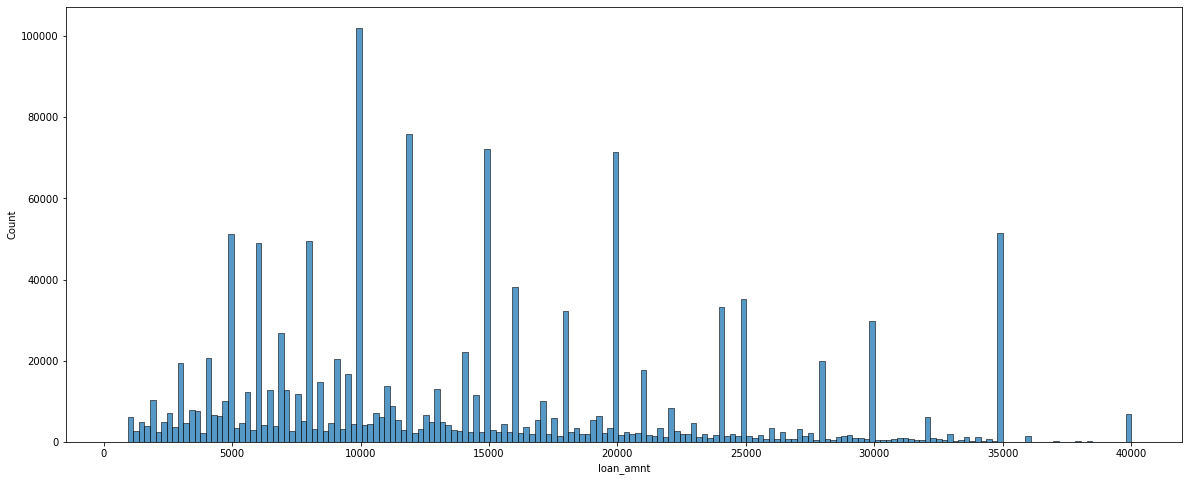

In [ ]:
plt.figure(figsize=(20, 8))
sns.histplot(accepted_loans['loan_amnt'])

## Seeing correlation between continuous features via heatmap

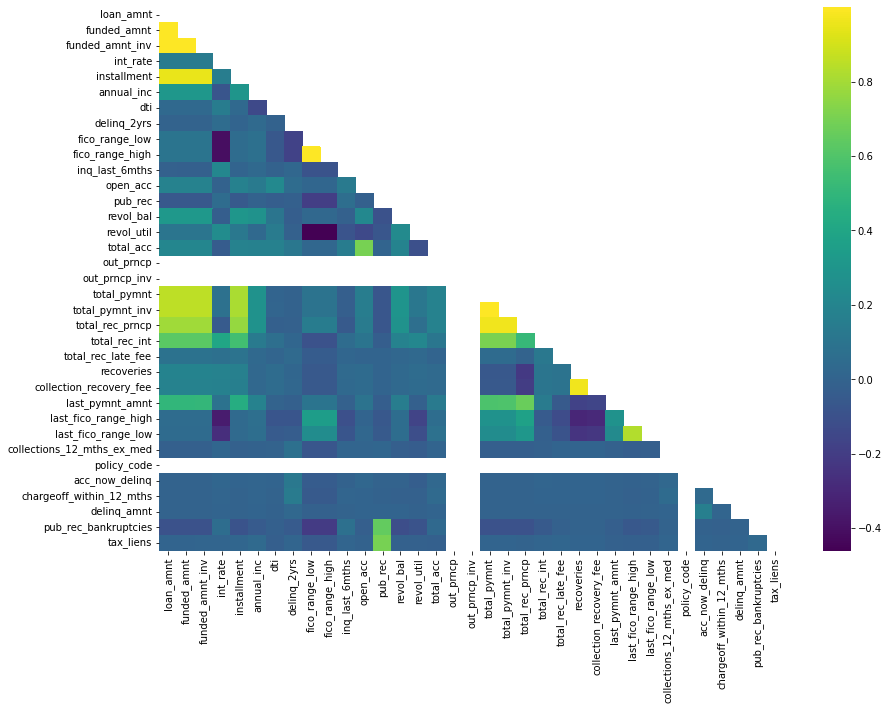

In [9]:
plt.figure(figsize=(14, 10))
mask = np.zeros_like(accepted_loans.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(accepted_loans.corr(), mask=mask, cmap='viridis')

There are 3 columns with a visible different behaviour: out_prncp, out_prncp_inv and policy_code

In [8]:
print(accepted_loans['out_prncp'].value_counts())
print(accepted_loans['out_prncp_inv'].value_counts())
print(accepted_loans['policy_code'].value_counts())

0.0    1345310
Name: out_prncp, dtype: int64
0.0    1345310
Name: out_prncp_inv, dtype: int64
1.0    1345310
Name: policy_code, dtype: int64


They are constant, so we can drop these features

In [9]:
dropping_columns = ['out_prncp', 'out_prncp_inv', 'policy_code']
accepted_loans = accepted_loans.drop(columns=dropping_columns)
accepted_loans.shape

(1345310, 53)

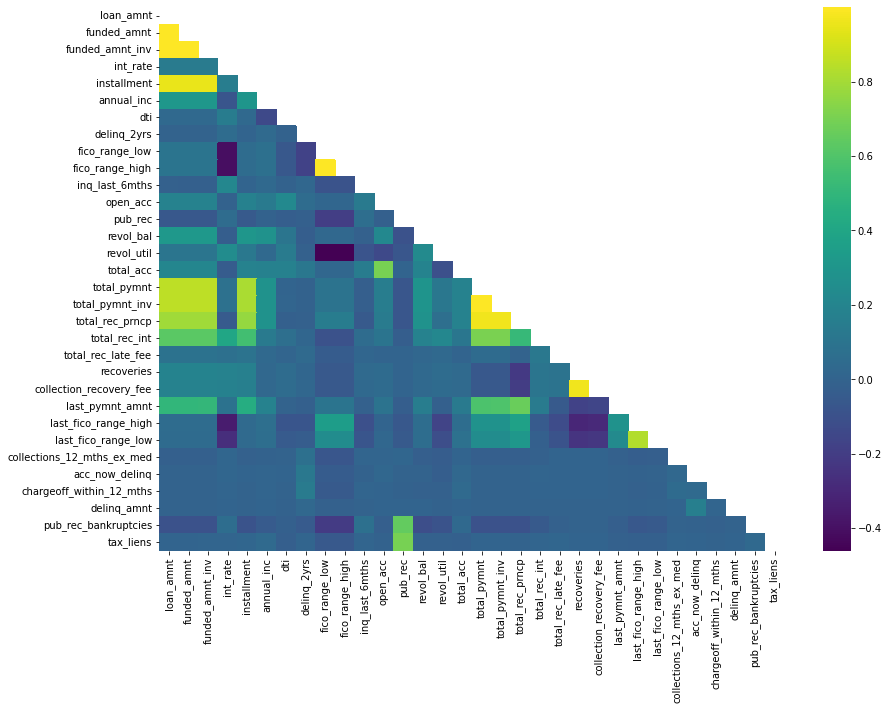

In [12]:
plt.figure(figsize=(14, 10))
mask = np.zeros_like(accepted_loans.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(accepted_loans.corr(), mask=mask, cmap='viridis')

## Leakage features

In [10]:
leakage_columns = ['last_pymnt_d', 'last_fico_range_low', 'issue_d', 'funded_amnt_inv', 'funded_amnt', 'last_fico_range_high', 'funded_amnt_inv', 'collection_recovery_fee', 'recoveries', 'total_rec_late_fee', 'total_rec_int', 'total_rec_prncp', 'total_pymnt_inv', 'total_pymnt']
possible_leakage_columns = ['last_credit_pull_d', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']

In [11]:
accepted_loans = accepted_loans.drop(columns=leakage_columns)

In [15]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 40 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1345310 non-null  object 
 1   loan_amnt                   1345310 non-null  float64
 2   term                        1345310 non-null  object 
 3   int_rate                    1345310 non-null  float64
 4   installment                 1345310 non-null  float64
 5   grade                       1345310 non-null  object 
 6   sub_grade                   1345310 non-null  object 
 7   home_ownership              1345310 non-null  object 
 8   annual_inc                  1345310 non-null  float64
 9   verification_status         1345310 non-null  object 
 10  loan_status                 1345310 non-null  object 
 11  pymnt_plan                  1345310 non-null  object 
 12  url                         1345310 non-null  object 
 1

Unstacking correlation to see highest correlation pairs

In [16]:
correlation_matrix = accepted_loans.corr().abs()
unstack_corr = correlation_matrix.unstack()
unstack_corr = unstack_corr.sort_values(ascending=False)

corr_df = pd.DataFrame(unstack_corr).drop_duplicates().reset_index()
corr_df.columns = ['feature 1', 'feature 2', 'corr']

# check pairs of feature having corr > 0.8
condition1 = corr_df['corr'] > 0.8
condition2 = corr_df['feature 1'] != corr_df['feature 2']
corr_df[condition1 & condition2]

,feature 1,feature 2,corr
1,fico_range_high,fico_range_low,1.000000
2,installment,loan_amnt,0.953401


## Performing scatter plot to check some correlations between variables

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


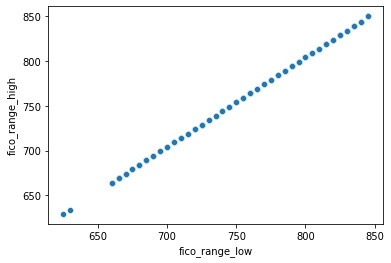

In [17]:
sns.scatterplot(accepted_loans['fico_range_low'], accepted_loans['fico_range_high'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


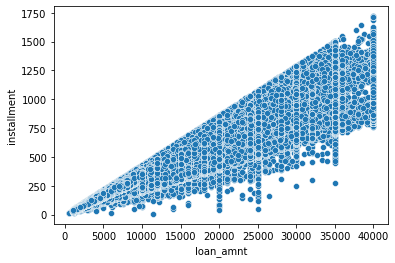

In [18]:
sns.scatterplot(accepted_loans['loan_amnt'], accepted_loans['installment'])

In [12]:
accepted_loans.drop('fico_range_low', inplace=True, axis=1)

In [20]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 39 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1345310 non-null  object 
 1   loan_amnt                   1345310 non-null  float64
 2   term                        1345310 non-null  object 
 3   int_rate                    1345310 non-null  float64
 4   installment                 1345310 non-null  float64
 5   grade                       1345310 non-null  object 
 6   sub_grade                   1345310 non-null  object 
 7   home_ownership              1345310 non-null  object 
 8   annual_inc                  1345310 non-null  float64
 9   verification_status         1345310 non-null  object 
 10  loan_status                 1345310 non-null  object 
 11  pymnt_plan                  1345310 non-null  object 
 12  url                         1345310 non-null  object 
 1

## Creating a new feature - loan_paid - that is 1 for 'Fully Paid' and 0 for 'Charged Off'

In [13]:
accepted_loans['loan_paid'] = accepted_loans['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)
accepted_loans = accepted_loans.drop(columns=['loan_status'])

## Working on categorical features

In [14]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 39 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1345310 non-null  object 
 1   loan_amnt                   1345310 non-null  float64
 2   term                        1345310 non-null  object 
 3   int_rate                    1345310 non-null  float64
 4   installment                 1345310 non-null  float64
 5   grade                       1345310 non-null  object 
 6   sub_grade                   1345310 non-null  object 
 7   home_ownership              1345310 non-null  object 
 8   annual_inc                  1345310 non-null  float64
 9   verification_status         1345310 non-null  object 
 10  pymnt_plan                  1345310 non-null  object 
 11  url                         1345310 non-null  object 
 12  purpose                     1345310 non-null  object 
 1

In [15]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))
accepted_loans[categorical_columns]

Index(['id', 'term', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'pymnt_plan', 'url', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_credit_pull_d', 'application_type', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
18


,id,term,grade,sub_grade,home_ownership,verification_status,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,C4,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,PA,Aug-2003,w,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,C1,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,SD,Dec-1999,w,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,B4,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,IL,Aug-2000,w,Mar-2019,Joint App,N,Cash,N
4,68476807,60 months,F,F1,MORTGAGE,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,PA,Jun-1998,w,Mar-2018,Individual,N,Cash,N
5,68426831,36 months,C,C3,RENT,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,300xx,GA,Oct-1987,w,May-2017,Individual,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,60 months,B,B2,OWN,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,775xx,TX,Jul-2004,f,Mar-2019,Individual,N,Cash,N
2260690,88948836,60 months,C,C3,MORTGAGE,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,900xx,CA,Mar-2002,f,Jul-2018,Individual,N,Cash,N
2260691,89996426,60 months,C,C4,MORTGAGE,Source Verified,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,863xx,AZ,Jun-2011,f,Dec-2018,Individual,N,Cash,N
2260692,90006534,60 months,C,C1,RENT,Not Verified,n,https://lendingclub.com/browse/loanDetail.acti...,medical,284xx,NC,Aug-1997,f,Mar-2019,Individual,N,Cash,N


### Dropping features 'id', 'pymnt_plan' and 'hardship_flag'

In [24]:
# constant features (pymnt_plan and hardship_flag)
print(accepted_loans['pymnt_plan'].value_counts())
print(accepted_loans['hardship_flag'].value_counts())

n    1345310
Name: pymnt_plan, dtype: int64
N    1345310
Name: hardship_flag, dtype: int64


In [16]:
dropping_columns = ['id', 'pymnt_plan', 'hardship_flag']
accepted_loans = accepted_loans.drop(columns=dropping_columns)
accepted_loans.shape

(1345310, 36)

In [17]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(len(categorical_columns))
print(categorical_columns)

15
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'url', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


### Features 'term'

In [28]:
print(accepted_loans['term'].value_counts())

 36 months    1020743
 60 months     324567
Name: term, dtype: int64


In [18]:
# convert term into either a 36 or 60 integer numeric data type
accepted_loans['term'] = accepted_loans['term'].apply(lambda x: 36 if x == '36 months' else 60) 
accepted_loans['term']

0          60
1          60
2          60
4          60
5          60
           ..
2260688    60
2260690    60
2260691    60
2260692    60
2260697    60
Name: term, Length: 1345310, dtype: int64

In [30]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['grade', 'sub_grade', 'home_ownership', 'verification_status', 'url',
       'purpose', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
14


### Features "grade" and "sub_grade"

In [31]:
print(accepted_loans['grade'].value_counts())

B    392741
C    381686
A    235090
D    200953
E     93650
F     32058
G      9132
Name: grade, dtype: int64


In [32]:
print(accepted_loans['sub_grade'].value_counts())

C1    85494
B4    83199
B5    82538
B3    81827
C2    79213
C3    74998
C4    74421
B2    74024
B1    71153
C5    67560
A5    64003
A4    52235
D1    51321
D2    44848
A1    43678
D3    39317
A3    37996
A2    37178
D4    35566
D5    29901
E1    23749
E2    21377
E3    18387
E4    15720
E5    14417
F1     9970
F2     7198
F3     6088
F4     4859
F5     3943
G1     2997
G2     2131
G3     1614
G4     1280
G5     1110
Name: sub_grade, dtype: int64


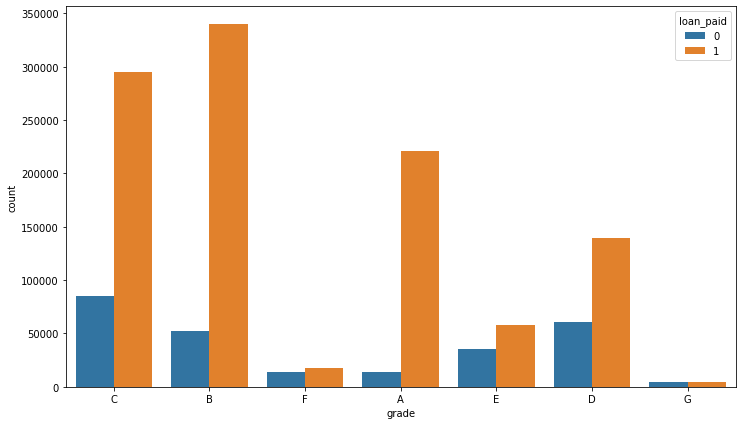

In [ ]:
# checking count per grade and loan_paid
plt.figure(figsize=(12, 7))
sns.countplot(x=accepted_loans['grade'], hue=accepted_loans['loan_paid'])

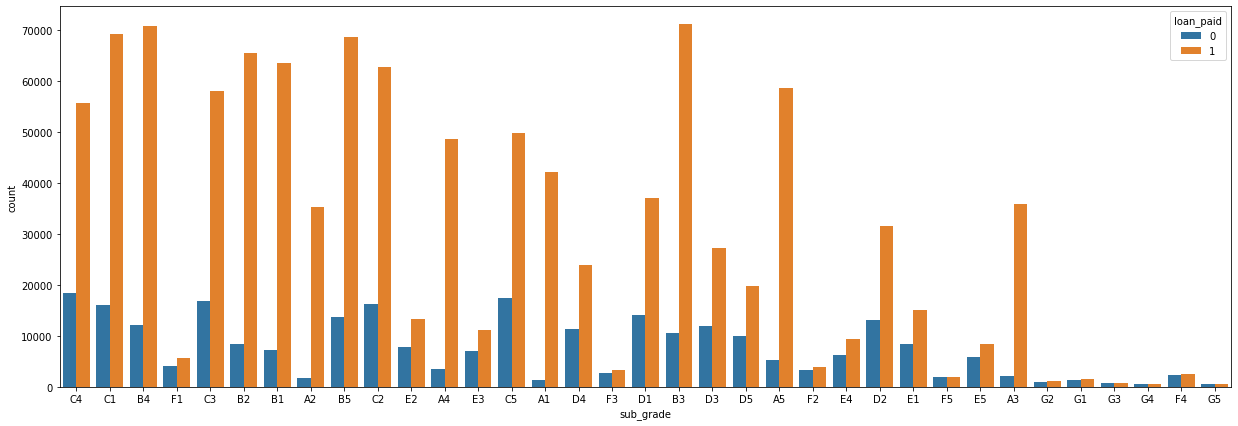

In [ ]:
# checking count per subgrade and loan_paid
plt.figure(figsize=(21, 7))
sns.countplot(x=accepted_loans['sub_grade'], hue=accepted_loans['loan_paid'])

In [19]:
# Since grade is part of sub_grade, so let's just drop the grade feature
accepted_loans.drop('grade', axis=1, inplace=True)

In [20]:
accepted_loans = pd.get_dummies(accepted_loans, columns=['sub_grade'], prefix='sub_grade', prefix_sep='_', drop_first=True)

In [21]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['home_ownership', 'verification_status', 'url', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
12


### Features 'verification_status', 'purpose', 'application_type', 'initial_list_status' and 'home_ownership'

In [24]:
dummies = ['verification_status', 'purpose', 'initial_list_status', 'application_type', 'home_ownership']
for dummy_var in dummies:
  print(accepted_loans[dummy_var].unique())

['Not Verified' 'Source Verified' 'Verified']
['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']
['w' 'f']
['Individual' 'Joint App']
['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE' 'OTHER']


For these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

In [25]:
for dummy_var in dummies:
  accepted_loans = pd.get_dummies(accepted_loans, prefix=dummy_var, columns=[dummy_var], drop_first=True)

In [26]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['url', 'zip_code', 'addr_state', 'earliest_cr_line',
       'last_credit_pull_d', 'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
7


### Features 'url', 'last_credit_pull_d' and 'earliest_cr_line'

In [ ]:
print(accepted_loans['url'].value_counts())

https://lendingclub.com/browse/loanDetail.action?loan_id=68407277     1
https://lendingclub.com/browse/loanDetail.action?loan_id=143889346    1
https://lendingclub.com/browse/loanDetail.action?loan_id=144187055    1
https://lendingclub.com/browse/loanDetail.action?loan_id=143508756    1
https://lendingclub.com/browse/loanDetail.action?loan_id=144206887    1
                                                                     ..
https://lendingclub.com/browse/loanDetail.action?loan_id=81376539     1
https://lendingclub.com/browse/loanDetail.action?loan_id=82257177     1
https://lendingclub.com/browse/loanDetail.action?loan_id=82020311     1
https://lendingclub.com/browse/loanDetail.action?loan_id=82010251     1
https://lendingclub.com/browse/loanDetail.action?loan_id=88224441     1
Name: url, Length: 1341026, dtype: int64


In [39]:
print(accepted_loans['last_credit_pull_d'].value_counts())

Mar-2019    470827
Feb-2019     74850
Jan-2019     61319
Jul-2018     53543
Oct-2016     50653
             ...  
May-2007         1
Jun-2008         1
Jul-2008         1
Dec-2007         1
Apr-2019         1
Name: last_credit_pull_d, Length: 140, dtype: int64


In [40]:
print(len(accepted_loans['earliest_cr_line'].unique()))

739


Let's drop these features

In [27]:
dropping_columns = ['url', 'last_credit_pull_d', 'earliest_cr_line']
accepted_loans = accepted_loans.drop(columns=dropping_columns)

In [28]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['zip_code', 'addr_state', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
4


### Features 'disbursement_method' and 'debt_settlement_flag'

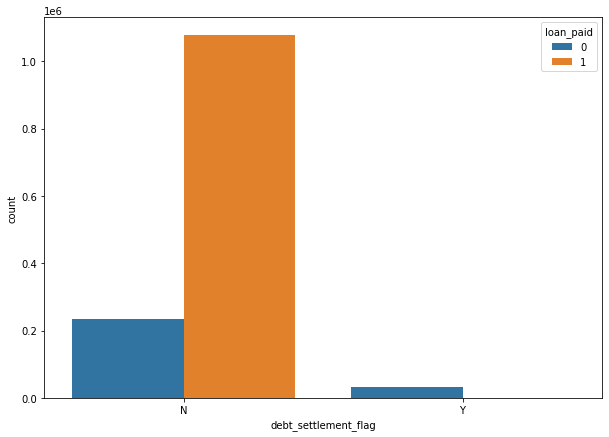

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(x=accepted_loans['debt_settlement_flag'], hue=accepted_loans['loan_paid'])

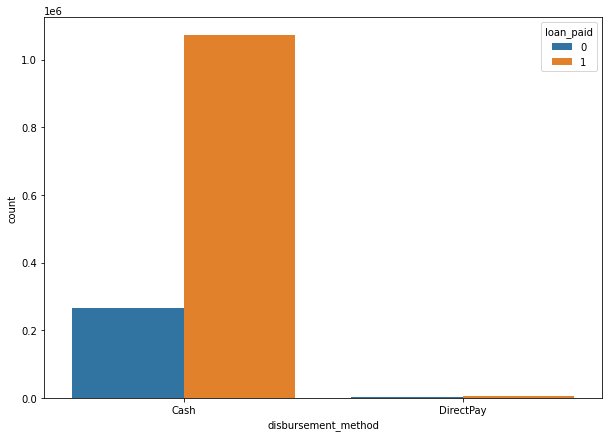

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(x=accepted_loans['disbursement_method'], hue=accepted_loans['loan_paid'])

In [ ]:
print(accepted_loans['disbursement_method'].value_counts())
print(accepted_loans['debt_settlement_flag'].value_counts())

Cash         1338410
DirectPay       6900
Name: disbursement_method, dtype: int64
N    1312034
Y      33276
Name: debt_settlement_flag, dtype: int64


It seem that these features can cause data leakage, let's drop these features first

In [29]:
#accepted_loans = pd.get_dummies(accepted_loans, columns = ['disbursement_method'], prefix='disbursement_method', drop_first=True)
#accepted_loans = pd.get_dummies(accepted_loans, columns = ['debt_settlement_flag'], prefix='debt_settlement_flag', drop_first=True)
dropping_columns = ['disbursement_method', 'debt_settlement_flag']
accepted_loans = accepted_loans.drop(columns=dropping_columns)

In [30]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index(['zip_code', 'addr_state'], dtype='object')
2


### Features 'zip_code' and 'addr_state'

In [ ]:
print(accepted_loans['zip_code'].value_counts())

945xx    15005
750xx    14474
112xx    13829
606xx    12433
300xx    12124
         ...  
095xx        1
009xx        1
872xx        1
513xx        1
525xx        1
Name: zip_code, Length: 943, dtype: int64


In [31]:
# Drop 'zip_code' feature
accepted_loans = accepted_loans.drop(columns=['zip_code'])

In [46]:
print(accepted_loans['addr_state'].unique())
print(len(accepted_loans['addr_state'].unique()))

['PA' 'SD' 'IL' 'GA' 'MN' 'SC' 'RI' 'NC' 'CA' 'VA' 'AZ' 'IN' 'MD' 'NY'
 'TX' 'KS' 'NM' 'AL' 'WA' 'OH' 'LA' 'FL' 'CO' 'MI' 'MO' 'DC' 'MA' 'WI'
 'HI' 'VT' 'NJ' 'DE' 'TN' 'NH' 'NE' 'OR' 'CT' 'AR' 'NV' 'WV' 'MT' 'WY'
 'OK' 'KY' 'MS' 'UT' 'ND' 'ME' 'AK' 'ID' 'IA']
51


51 states :::)))

The 51st state may be the state of aliens :::)))

Let's first drop this feature also

In [32]:
accepted_loans.drop('addr_state', inplace=True, axis=1)
#accepted_loans = pd.get_dummies(accepted_loans, columns=['addr_state'], prefix='addr_state', drop_first=True)

In [33]:
categorical_columns = accepted_loans.select_dtypes(include='object').columns
print(categorical_columns)
print(len(categorical_columns))

Index([], dtype='object')
0


In [49]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 78 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1345310 non-null  float64
 1   term                                 1345310 non-null  int64  
 2   int_rate                             1345310 non-null  float64
 3   installment                          1345310 non-null  float64
 4   annual_inc                           1345310 non-null  float64
 5   dti                                  1344936 non-null  float64
 6   delinq_2yrs                          1345310 non-null  float64
 7   fico_range_high                      1345310 non-null  float64
 8   inq_last_6mths                       1345309 non-null  float64
 9   open_acc                             1345310 non-null  float64
 10  pub_rec                              1345310 non-null  float64
 11

## Handling missing data

In [34]:
(accepted_loans.isnull().sum() / len(accepted_loans) * 100).sort_values(ascending=False).head(10)

revol_util                      0.063703
pub_rec_bankruptcies            0.051810
dti                             0.027800
chargeoff_within_12_mths        0.004163
collections_12_mths_ex_med      0.004163
tax_liens                       0.002899
inq_last_6mths                  0.000074
sub_grade_G3                    0.000000
purpose_credit_card             0.000000
verification_status_Verified    0.000000
dtype: float64

There are 7 features having missing values but all of them account for less than 0.1% -> Let's drop any rows with missing values

In [35]:
accepted_loans = accepted_loans.dropna()

# Model Building and Training

## ANN

### Features and labels

In [36]:
features = accepted_loans.loc[:, accepted_loans.columns != 'loan_paid'].values
labels = accepted_loans['loan_paid'].values

### Train test split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

### Min max scalar

In [38]:
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
print(X_train.shape)
print(X_test.shape)

(1074704, 77)
(268676, 77)


### Building model

In [58]:
model = Sequential()

model = Sequential()
model.add(Dense(units=78,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=39,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=19,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=8,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=4,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

### Traning

In [59]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=50,
          batch_size=512,
          verbose=1)

Epoch 1/50
2100/2100 [==============================] - 17s 7ms/step - loss: 0.3601
Epoch 2/50
2100/2100 [==============================] - 13s 6ms/step - loss: 0.2799
Epoch 3/50
2100/2100 [==============================] - 13s 6ms/step - loss: 0.2615
Epoch 4/50
2100/2100 [==============================] - 13s 6ms/step - loss: 0.2544
Epoch 5/50
2100/2100 [==============================] - 14s 7ms/step - loss: 0.2520
Epoch 6/50
2100/2100 [==============================] - 13s 6ms/step - loss: 0.2494
Epoch 7/50
2100/2100 [==============================] - 14s 6ms/step - loss: 0.2479
Epoch 8/50
2100/2100 [==============================] - 13s 6ms/step - loss: 0.2460
Epoch 9/50
2100/2100 [==============================] - 13s 6ms/step - loss: 0.2448
Epoch 10/50
2100/2100 [==============================] - 13s 6ms/step - loss: 0.2444
Epoch 11/50
2100/2100 [==============================] - 15s 7ms/step - loss: 0.2431
Epoch 12/50
2100/2100 [==============================] - 13s 6ms/step - lo

## Model Evaluating

In [45]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [61]:
losses = pd.DataFrame(model.history.history)

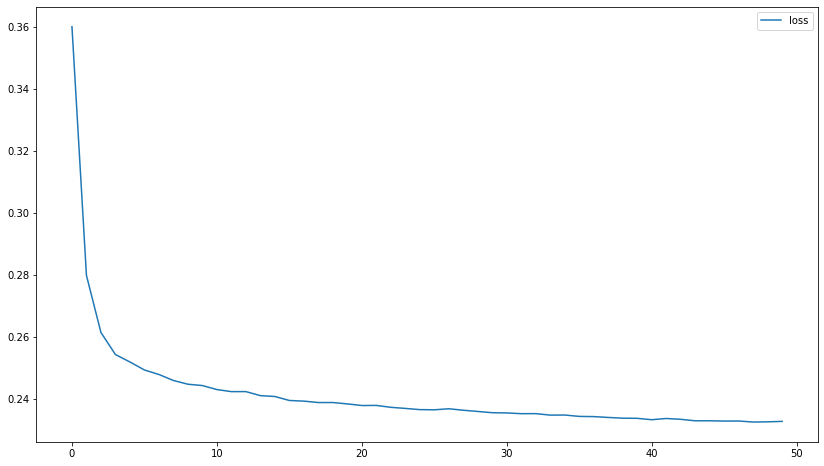

In [62]:
losses[['loss']].plot(figsize=(14, 8))

In [68]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
print_score(y_test, predictions, train=False)
print(f1_score(predictions, y_test))

Test Result:
Accuracy Score: 89.10%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.794113       0.908445  0.890965       0.851279       0.885697
recall         0.610191       0.960705  0.890965       0.785448       0.890965
f1-score       0.690108       0.933844  0.890965       0.811976       0.885349
support    53457.000000  215219.000000  0.890965  268676.000000  268676.000000
_______________________________________________
Confusion Matrix: 
 [[ 32619  20838]
 [  8457 206762]]

0.9338443020737593


In [81]:
print(roc_auc_score(predictions, y_test))

0.851278995290311


## RandomForest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf_clf = RandomForestClassifier(n_estimators=100)

In [42]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

In [46]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)
print(f1_score(y_test_pred, y_test))

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       1.000000       0.999999  0.999999  9.999994e-01  9.999991e-01
recall          0.999995       1.000000  0.999999  9.999977e-01  9.999991e-01
f1-score        0.999998       0.999999  0.999999  9.999985e-01  9.999991e-01
support    214732.000000  859972.000000  0.999999  1.074704e+06  1.074704e+06
_______________________________________________
Confusion Matrix: 
 [[214731      1]
 [     0 859972]]

Test Result:
Accuracy Score: 89.04%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.764103       0.916055  0.890359       0.840079       0.885822
recall         0.649438       0.950200  0.890359       0.799819       0.890359
f1-score       0.702119       0.932815  0.890359     

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


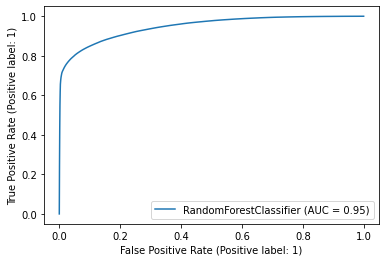

In [47]:
plot_roc_curve(rf_clf, X_test, y_test)

In [48]:
print(roc_auc_score(y_test_pred, y_test))

0.8400787053292641


## Logistic regression

In [72]:
from sklearn.linear_model import LogisticRegression

In [73]:
clf = LogisticRegression()

In [77]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [78]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [79]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)
print(f1_score(y_test_pred, y_test))

Train Result:
Accuracy Score: 86.63%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.709686       0.895554  0.866269  8.026200e-01  8.584165e-01
recall          0.559623       0.942838  0.866269  7.512304e-01  8.662692e-01
f1-score        0.625784       0.918588  0.866269  7.721859e-01  8.600839e-01
support    214732.000000  859972.000000  0.866269  1.074704e+06  1.074704e+06
_______________________________________________
Confusion Matrix: 
 [[120169  94563]
 [ 49158 810814]]

Test Result:
Accuracy Score: 86.63%
_______________________________________________
CLASSIFICATION REPORT:
                      0              1  accuracy      macro avg   weighted avg
precision      0.707495       0.896013  0.866345       0.801754       0.858504
recall         0.559609       0.942533  0.866345       0.751071       0.866345
f1-score       0.624922       0.918684  0.866345      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


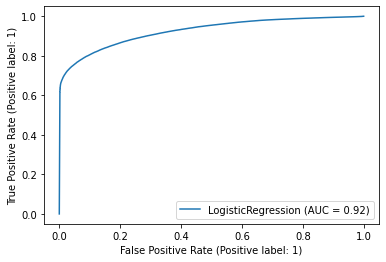

In [80]:
plot_roc_curve(clf, X_test, y_test)

In [82]:
print(roc_auc_score(y_test_pred, y_test))

0.8017537118712507
